# Parallel ACO Performance Analysis

This notebook loads `aco_best.csv`, computes performance metrics, and visualizes:
- Execution Time
- Speedup
- Efficiency
- Cost

Each plot is saved under the `plots/` directory.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load CSV
df = pd.read_csv('aco_best.csv')
df

,threads,plant,time,bestMSE,Kp,Ki,Kd
0,1,1,25.32380,0.000767,9.83333,9.83333,0.833333
1,1,2,27.71710,0.001868,9.83333,6.50000,1.166670
2,1,3,33.81100,0.006816,7.83333,5.16667,3.500000
3,2,1,12.68260,0.000898,9.83333,9.50000,0.500000
4,2,2,13.85110,0.001987,9.83333,7.50000,1.833330
5,2,3,16.99670,0.006757,8.83333,5.50000,3.833330
6,4,1,7.15697,0.000775,9.83333,9.16667,0.833333
7,4,2,7.79420,0.001883,9.50000,8.16667,1.500000
8,4,3,9.59759,0.006700,9.50000,5.50000,4.166670
9,6,1,6.11383,0.000898,9.83333,9.50000,0.500000


In [3]:
def compute_speedup(df_p):
    T1 = df_p[df_p['threads'] == 1]['time'].values[0]
    return T1 / df_p['time']

def compute_efficiency(df_p):
    return df_p['speedup'] / df_p['threads']

def compute_cost(df_p):
    return df_p['threads'] * df_p['time']

plants = {1: 'G1(s)', 2: 'G2(s)', 3: 'G3(s)'}

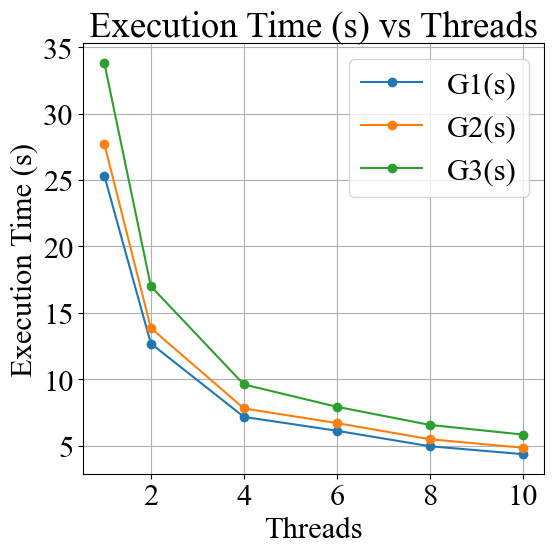

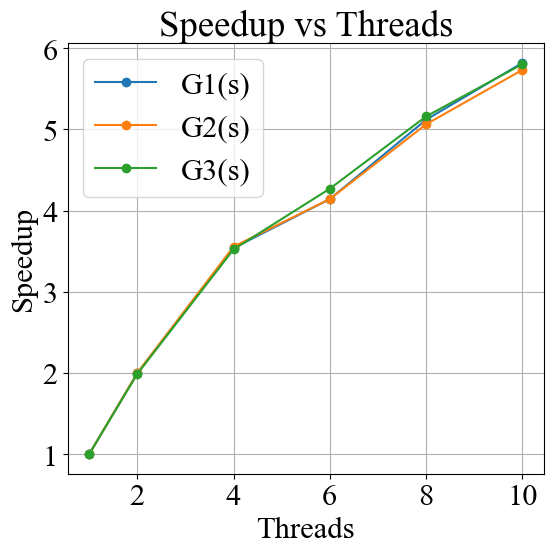

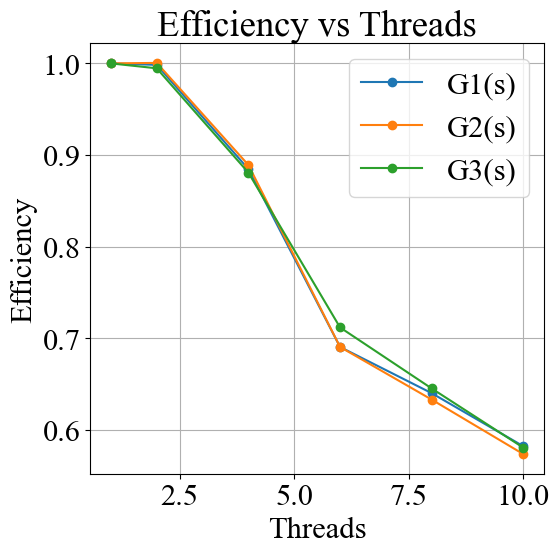

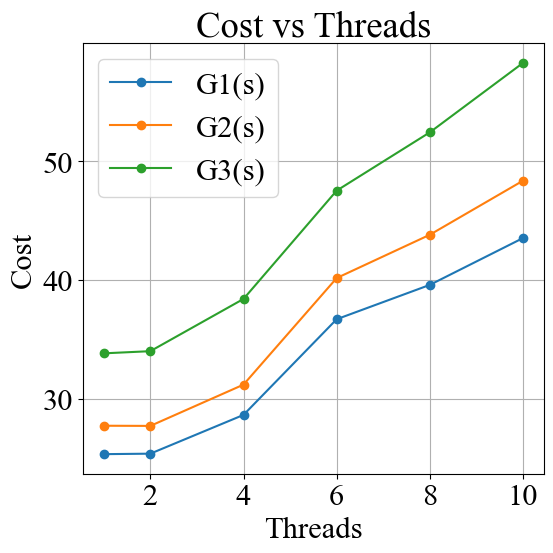

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 22

os.makedirs('plots', exist_ok=True)

# Prepare combined dataset
plants = {1: "G1(s)", 2: "G2(s)", 3: "G3(s)"}

# Dictionary to hold computed results
data = {}

for p in plants:
    df_p = df[df["plant"] == p].sort_values("threads").copy()
    df_p["speedup"] = compute_speedup(df_p)
    df_p["efficiency"] = compute_efficiency(df_p)
    df_p["cost"] = compute_cost(df_p)
    data[p] = df_p



# plotting function
def plot_all(metric, ylabel, filename):
    plt.figure(figsize=(6, 6))

    for p in plants:
        df_p = data[p]
        plt.plot(df_p["threads"], df_p[metric],
                 marker='o', label=plants[p])

    plt.xlabel("Threads")
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs Threads")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/{filename}.pdf")
    plt.show()


# Generate the four plots
plot_all("time", "Execution Time (s)", "execution_time")
plot_all("speedup", "Speedup", "speedup")
plot_all("efficiency", "Efficiency", "efficiency")
plot_all("cost", "Cost", "cost")


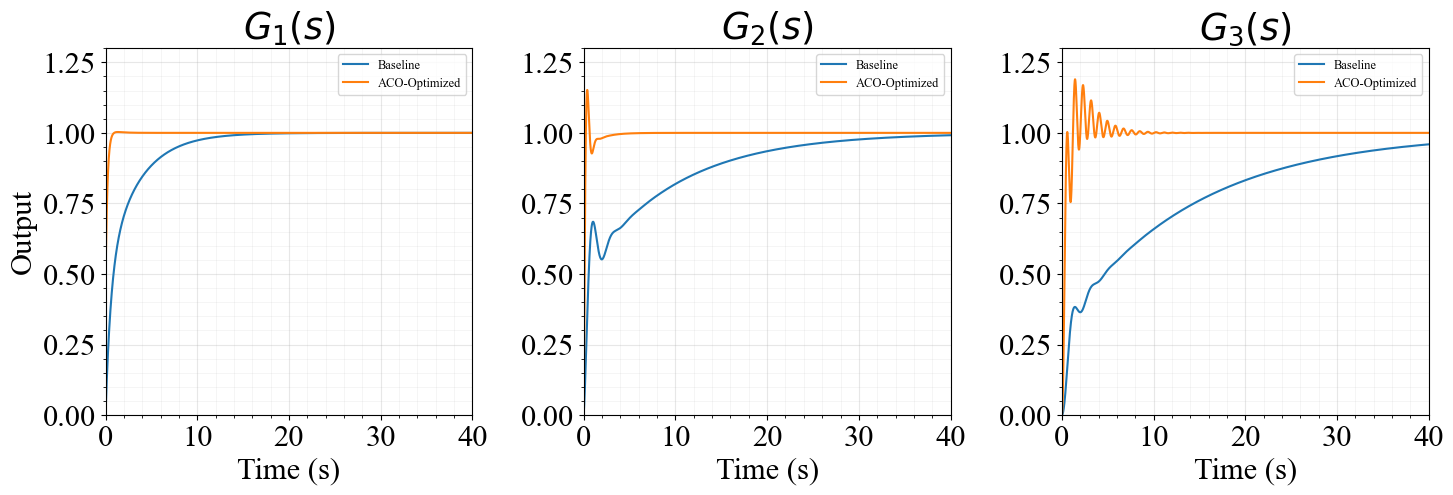


=== Step Response Metrics (Baseline vs ACO) ===
         case plant      Kp      Ki       Kd  rise_time  peak_time  overshoot_pct  settling_time  steady_state_error      MSE
     Baseline    G1 1.00000 0.50000 0.000000      5.388     39.999       0.000000         10.990        4.090662e-06 0.018750
ACO-Optimized    G1 9.83333 9.83333 0.833333      0.335      1.337       0.301606          0.619        6.883383e-15 0.000767
     Baseline    G2 1.00000 0.20000 0.100000     15.654     39.999       0.000000         31.492        8.360699e-03 0.034625
ACO-Optimized    G2 9.83333 7.16667 1.166670      0.181      0.387      15.217168          1.900        1.443290e-14 0.001866
     Baseline    G3 0.50000 0.10000 0.100000     26.867     39.999       0.000000            NaN        4.062608e-02 0.092974
ACO-Optimized    G3 9.50000 5.50000 4.166670      0.338      1.443      18.976997          5.954        1.130807e-09 0.006700

Saved metrics to: aco_step_metrics.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO


def get_plant(choice: int):
    if choice == 1:   # G1(s) = 1/(s+1)
        num = np.array([1.0])
        den = np.array([1.0, 1.0])
    elif choice == 2: # G2(s) = 5/(s^2 + 2s + 5)
        num = np.array([5.0])
        den = np.array([1.0, 2.0, 5.0])
    elif choice == 3: # G3(s) = 10/((s+1)(s^2+2s+10)) = 10/(s^3+3s^2+12s+10)
        num = np.array([10.0])
        den = np.array([1.0, 3.0, 12.0, 10.0])
    else:
        raise ValueError("choice must be 1,2,3")
    return num, den


def simulate_pid(num, den, Kp, Ki, Kd, dt=0.001, sim_time=40.0, r=1.0,
                 u_max=1e3, i_max=1e3, y_max=1e6):
    steps = int(sim_time / dt)
    t = np.linspace(0.0, sim_time, steps, endpoint=False)

   
    x1 = 0.0
    x2 = 0.0
    x3 = 0.0
    y  = 0.0

    integral = 0.0
    prev_err = 0.0

    y_hist = np.zeros(steps)
    u_hist = np.zeros(steps)
    e_hist = np.zeros(steps)

    for k in range(steps):
        e = r - y

        # PID
        integral += e * dt
        integral = np.clip(integral, -i_max, i_max)

        derivative = (e - prev_err) / dt
        u = Kp * e + Ki * integral + Kd * derivative
        u = np.clip(u, -u_max, u_max)

        # plant update
        den_size = len(den)
        if den_size == 2:
            # y' = -a*y + b*u, with a=den[1], b=num[0]
            a = den[1]
            b = num[0]
            y += dt * (-a * y + b * u)

        elif den_size == 3:
            # y'' + a1*y' + a0*y = b*u
            a1 = den[1]
            a0 = den[2]
            b  = num[0]
            y_ddot = b * u - a1 * x2 - a0 * x1
            x2 += dt * y_ddot
            x1 += dt * x2
            y  = x1

        elif den_size == 4:
            # y''' + a2*y'' + a1*y' + a0*y = b*u
            a2 = den[1]
            a1 = den[2]
            a0 = den[3]
            b  = num[0]
            y_dddot = b * u - a2 * x3 - a1 * x2 - a0 * x1
            x3 += dt * y_dddot
            x2 += dt * x3
            x1 += dt * x2
            y  = x1
        else:
            raise ValueError("Unsupported den size")

        if not np.isfinite(y) or abs(y) > y_max:
            y_hist[k:] = np.nan
            u_hist[k:] = np.nan
            e_hist[k:] = np.nan
            break

        y_hist[k] = y
        u_hist[k] = u
        e_hist[k] = e
        prev_err = e

    # MSE
    if np.all(np.isnan(e_hist)):
        mse = 1e9
    else:
        mse = np.nanmean(e_hist**2)

    return t, y_hist, u_hist, e_hist, mse


def step_metrics(t, y, r=1.0, settle_band=0.02):

    if np.any(np.isnan(y)):
        return {
            "rise_time": np.nan,
            "settling_time": np.nan,
            "overshoot_pct": np.nan,
            "steady_state_error": np.nan,
            "peak_time": np.nan,
            "peak_value": np.nan,
        }

    y_final = y[-1]
    ess = abs(r - y_final)

    # peak
    peak_idx = int(np.argmax(y))
    peak_val = float(y[peak_idx])
    peak_time = float(t[peak_idx])

    # overshoot (% relative to reference)
    overshoot = max(0.0, (peak_val - r) / r * 100.0)

    # rise time
    y10 = 0.1 * r
    y90 = 0.9 * r

    def first_cross(level):
        idx = np.where(y >= level)[0]
        return float(t[idx[0]]) if len(idx) else np.nan

    t10 = first_cross(y10)
    t90 = first_cross(y90)
    rise_time = (t90 - t10) if (np.isfinite(t10) and np.isfinite(t90)) else np.nan

    # settling time
    band_lo = (1.0 - settle_band) * r
    band_hi = (1.0 + settle_band) * r
    within = (y >= band_lo) & (y <= band_hi)

    settling_time = np.nan
    for i in range(len(y)):
        if within[i] and np.all(within[i:]):
            settling_time = float(t[i])
            break

    return {
        "rise_time": float(rise_time) if np.isfinite(rise_time) else np.nan,
        "settling_time": settling_time,
        "overshoot_pct": float(overshoot),
        "steady_state_error": float(ess),
        "peak_time": float(peak_time),
        "peak_value": float(peak_val),
    }
# ACO best CSV input 
# Pick best per plant = minimum bestMSE across threads

aco_csv_text = """threads,plant,time,bestMSE,Kp,Ki,Kd
1,1,25.3238,0.000766896,9.83333,9.83333,0.833333
1,2,27.7171,0.00186798,9.83333,6.5,1.16667
1,3,33.811,0.0068159,7.83333,5.16667,3.5
2,1,12.6826,0.000898077,9.83333,9.5,0.5
2,2,13.8511,0.00198723,9.83333,7.5,1.83333
2,3,16.9967,0.0067574,8.83333,5.5,3.83333
4,1,7.15697,0.000775447,9.83333,9.16667,0.833333
4,2,7.7942,0.00188333,9.5,8.16667,1.5
4,3,9.59759,0.00669983,9.5,5.5,4.16667
6,1,6.11383,0.000898077,9.83333,9.5,0.5
6,2,6.69147,0.00189527,8.83333,7.5,1.16667
6,3,7.91812,0.00669983,9.5,5.5,4.16667
8,1,4.94692,0.00111581,9.83333,9.5,0.166667
8,2,5.4745,0.00186831,9.83333,8.16667,1.16667
8,3,6.55225,0.00675732,8.83333,5.16667,3.83333
10,1,4.35172,0.000898077,9.83333,9.5,0.5
10,2,4.83458,0.00186591,9.83333,7.16667,1.16667
10,3,5.82614,0.00675732,8.83333,5.16667,3.83333
"""

aco_df = pd.read_csv(StringIO(aco_csv_text))
aco_best_per_plant = (
    aco_df.sort_values("bestMSE")
          .groupby("plant", as_index=False)
          .first()
          .sort_values("plant")
)


# Baseline PID gains 
baseline_gains = {
    1: dict(Kp=1.0, Ki=0.5, Kd=0.0),
    2: dict(Kp=1.0, Ki=0.2, Kd=0.1),
    3: dict(Kp=0.5, Ki=0.1, Kd=0.1),
}

# Simulation settings 
dt = 0.001
sim_time = 40.0
r = 1.0



results_rows = []

baseline_sims = {}
aco_sims = {}

for plant in [1, 2, 3]:
    num, den = get_plant(plant)

    # baseline
    bg = baseline_gains[plant]
    tb, yb, ub, eb, mse_b = simulate_pid(num, den, bg["Kp"], bg["Ki"], bg["Kd"], dt, sim_time, r)
    met_b = step_metrics(tb, yb, r=r)
    met_b["MSE"] = mse_b
    results_rows.append({
        "case": "Baseline",
        "plant": f"G{plant}",
        "Kp": bg["Kp"], "Ki": bg["Ki"], "Kd": bg["Kd"],
        **met_b
    })
    baseline_sims[plant] = (tb, yb)

    # ACO best (min bestMSE per plant)
    row = aco_best_per_plant[aco_best_per_plant["plant"] == plant].iloc[0]
    Kp, Ki, Kd = float(row["Kp"]), float(row["Ki"]), float(row["Kd"])

    ta, ya, ua, ea, mse_a = simulate_pid(num, den, Kp, Ki, Kd, dt, sim_time, r)
    met_a = step_metrics(ta, ya, r=r)
    met_a["MSE"] = mse_a
    results_rows.append({
        "case": "ACO-Optimized",
        "plant": f"G{plant}",
        "Kp": Kp, "Ki": Ki, "Kd": Kd,
        **met_a
    })
    aco_sims[plant] = (ta, ya)

metrics_df = pd.DataFrame(results_rows)
plot_dir = "plots"

out_dir = "plots/"



fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

xlim = (0, 40)
ylim = (0, 1.3)

x_ticks = np.arange(0, 41, 10)    
y_ticks = np.arange(0, 1.31, 0.25) 

for idx, plant in enumerate([1, 2, 3]):
    tb, yb = baseline_sims[plant]
    ta, ya = aco_sims[plant]

    ax = axes[idx]
    ax.plot(tb, yb, label="Baseline")
    ax.plot(ta, ya, label="ACO-Optimized")

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    ax.set_title(rf"$G_{plant}(s)$")
    ax.set_xlabel("Time (s)")
    if idx == 0:
        ax.set_ylabel("Output")


    ax.minorticks_on()
    ax.grid(True, which="major", alpha=0.30, linewidth=0.8)
    ax.grid(True, which="minor", alpha=0.15, linewidth=0.6)


    ax.set_box_aspect(1)  

for ax in axes:
    ax.legend(loc="upper right", fontsize=9, frameon=True)

for ax in axes:
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)

plt.tight_layout()
plt.savefig(f"{out_dir}/aco_pid_all.pdf", format="pdf", bbox_inches="tight")
plt.show()



cols = ["case", "plant", "Kp", "Ki", "Kd",
        "rise_time", "peak_time", "overshoot_pct",
        "settling_time", "steady_state_error", "MSE"]
print("\n=== Step Response Metrics (Baseline vs ACO) ===")
print(metrics_df[cols].to_string(index=False))

metrics_df.to_csv("aco_step_metrics.csv", index=False)
print("\nSaved metrics to: aco_step_metrics.csv")
